# Step 1: Preprocessing

## 1.1 Import libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

## 1.2 Description about dataset

In [2]:
# import dataset
df = pd.read_csv("heart.csv")

* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.shape

(918, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
df.describe(include = 'O')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## 1.3 Visualization


In [ ]:
# Overall about output of database
partition = list(df['HeartDisease'].value_counts())
plt.subplot(1,2,1)
plt.pie(partition,
        labels = ['Normal','Heart Disease'],
        autopct='%1.1f%%',
        startangle = 90,
        explode = (0.1,0),
        shadow= True,
       )
plt.title('Heart Disease %');

In [ ]:
numerical_values=df[['Age', 'RestingECG', 'Cholesterol', 'MaxHR', 'Oldpeak']]
categorical_values=df[['Sex', 'ChestPainType','FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope', 'HeartDisease']]

In [ ]:
category=list(categorical_values)
numerical= list(numerical_values)

In [ ]:
#Impact of Categorical Features on the output
fig, ax = plt.subplots(nrows = 1,ncols = 6,figsize = (20,6))
color= ['#ADD8E6','#E0FFFF']
for i in range(len(category) - 1):
    plt.subplot(1,6,i+1)
    ax = sns.countplot(x=category[i], data = categorical_values,hue = "HeartDisease",palette = color,edgecolor = 'black')
plt.suptitle('Impact of Categorical Features on the output')

In [ ]:
sns.histplot(data = df ,x = 'Age', hue = 'HeartDisease')
plt.title("Distribution of Heart Diseases over Age")

In [ ]:
px.histogram(data_frame = df, x = 'Sex', color = 'HeartDisease', title="Distribution of Heart Diseases over Sex",barmode="group")

In [ ]:
sns.histplot(data = df ,x = 'RestingECG', hue = 'HeartDisease',palette = 'Set1')
plt.title("Distribution of Heart Diseases over RestingECG")

In [ ]:
px.histogram(data_frame = df, x = 'ChestPainType', color = 'HeartDisease', title="Distribution of Heart Diseases over ChestPainType",barmode="group")

In [ ]:
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

In [ ]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distrubution of RestingBP")
fig.show()

In [ ]:
fig = px.box(df,y="Age",x="HeartDisease",title=f"Distrubution of Age",color="Sex")
fig.show()

In [ ]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distrubution of Cholesterol",color="Sex")
fig.show()

In [ ]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distrubution of Oldpeak")
fig.show()

In [ ]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distrubution of MaxHR",color="Sex")
fig.show()

## 1.4 Preprocessing

In [9]:
data = pd.get_dummies(df,columns=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'],drop_first=True)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [10]:
data = data.astype(int)

<Axes: >

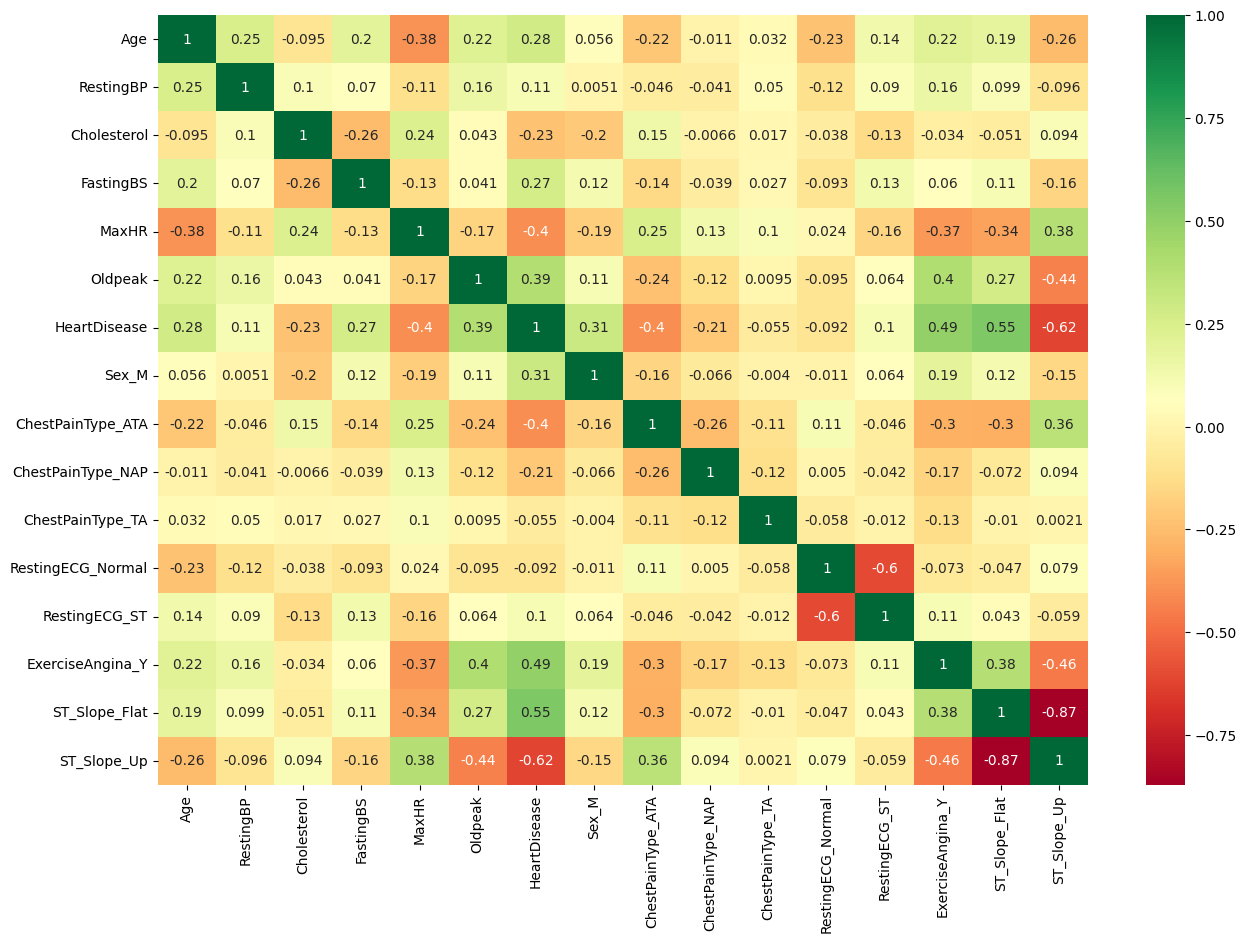

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn')

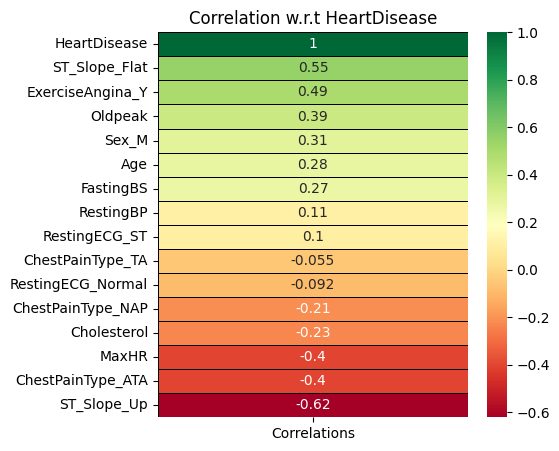

In [12]:
corr = data.corrwith(data['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap= 'RdYlGn',linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

In [15]:
X = data.drop(['HeartDisease'],axis=1)
y = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalize= MinMaxScaler()
standard= StandardScaler()
X_train['Oldpeak']= normalize.fit_transform(X_train[['Oldpeak']])
X_train[numerical_features]= standard.fit_transform(X_train[numerical_features])

In [17]:
X_test[numerical_features]= standard.transform(X_test[numerical_features])
X_test['Oldpeak']= normalize.transform(X_test[['Oldpeak']])

# Step 2: Model

## Apply Model 1: KNN

In [19]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
model_KNN = KNeighborsClassifier()
param_KNN = {
    'n_neighbors': [x for x in range(1,20,1)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
gridsearch_KNN = GridSearchCV(estimator=model_KNN, param_grid=param_KNN, scoring='accuracy',cv=kfold)
gridsearch_KNN.fit(X_train, y_train);

In [ ]:
print(f'The best accuracy score for trainning dataset is {gridsearch_KNN.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_KNN.best_params_}')

In [ ]:
#predict the target on the test dataset
predict_test_KNN = gridsearch_KNN.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test_KNN)
print('accuracy_score on test dataset : ', accuracy_test)

## Apply model 2: GaussianNB 

In [ ]:
param_NB = {
    "var_smoothing": np.logspace(0, -9, num=100)
}
model_NB= GaussianNB()
gridsearch_NB = GridSearchCV(estimator = model_NB, param_grid=param_NB, scoring='accuracy', cv=kfold, n_jobs=-1)
gridsearch_NB.fit(X_train, y_train)

In [ ]:
print(f'The best accuracy score for trainning dataset is {gridsearch_NB.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_NB.best_params_}')

In [ ]:
#predict the target on the test dataset
predict_test_NB = gridsearch_NB.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test_NB)
print('accuracy_score on test dataset : ', accuracy_test)

In [ ]:
results_NB = pd.DataFrame(gridsearch_NB.cv_results_['params'])
results_NB['test_score'] = gridsearch_NB.cv_results_['mean_test_score']
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

## Apply model 3: SVC

In [ ]:
param_SVC = {'C':[0.1,1, 10, 100],
               'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly', 'sigmoid']
               }
model_SVC = SVC()
gridsearch_SVC = GridSearchCV(estimator=model_SVC, param_grid=param_SVC, scoring='accuracy', n_jobs=-1, cv=kfold)
gridsearch_SVC.fit(X_train, y_train)

In [ ]:
print(f'The best accuracy score for trainning dataset is {gridsearch_SVC.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_SVC.best_params_}')

In [ ]:
#predict the target on the test dataset
predict_test_SVC = gridsearch_SVC.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test_SVC)
print('accuracy_score on test dataset : ', accuracy_test)

## Apply model 4: MLP

In [ ]:
mlp = MLPClassifier()

# Define the parameter grid
param_MLP = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
gridsearch_MLP = GridSearchCV(estimator=mlp, param_grid=param_MLP, scoring='accuracy', cv=kfold)
gridsearch_MLP.fit(X_train, y_train)


In [ ]:
print(f'The best accuracy score for trainning dataset is {gridsearch_MLP.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_MLP.best_params_}')

## Apply model 5: Logistic Regression

In [ ]:
param_Logistic= {
           'C': [1, 5, 10,15],
           'penalty': ['l1', 'l2', 'none']
}
model_Logistic = LogisticRegression()
gridsearch_Logistic = GridSearchCV(estimator=model_Logistic, param_grid=param_Logistic, scoring='accuracy',cv=kfold)
gridsearch_Logistic.fit(X_train, y_train)

In [ ]:
print(f'The best accuracy score for trainning dataset is {gridsearch_Logistic.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_Logistic.best_params_}')

## Apply model 6: Random Forest

In [ ]:
param_RF = dict(n_estimators=np.array([100, 200,250,300,350,400,450,500,550,600, 640]))
model_RF = RandomForestClassifier()
gridsearch_RF = GridSearchCV(estimator=model_RF, param_grid=param_RF, cv=kfold)
gridsearch_RF.fit(X_train, y_train)
print(f'The best accuracy score for trainning dataset is {gridsearch_RF.best_score_:.2%}')
print(f'The best hyperparameters are {gridsearch_RF.best_params_}')

# Step 3: Metrics

# Step 4: exited model

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

In [ ]:
# X = df.drop(['HeartDisease','RestingBP', 'RestingECG'],axis=1)
# y = df['HeartDisease']
# skf = StratifiedKFold(n_splits=5, random_state=None)
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]


## Grid Search


In [28]:
# Define the models and their parameters
models_params = {
    'KNeighborsClassifier': (KNeighborsClassifier(), {
        'n_neighbors': [x for x in range(1,15,1)],
        'weights': ['uniform', 'distance'],
        'leaf_size': [1, 2, 3, 5, 10],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }),
    'GaussianNB': (GaussianNB(), {
        "var_smoothing": np.logspace(0, -9, num=100)
    }),
    'SVC': (SVC(), {
        'C':[0.01, 0.1,1, 10, 15, 20],
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    }),
    'MLPClassifier': (MLPClassifier(), {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'early_stopping': [True, False],
        'learning_rate': ['constant','adaptive'],
    }),
    'LogisticRegression': (LogisticRegression(), {
        'C': [5, 10,15],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l1', 'l2', 'none']
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'n_estimators': np.array([100, 200,250,300,350,400,450,500,550,600, 650]),
        'max_depth': [3,4,5,6],
    })
}

kfold = KFold(n_splits=5, random_state=None, shuffle=True)

# Loop over the models and parameters to perform the grid search
for model_name, (model, params) in models_params.items():
    gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=kfold ,n_jobs = -1)
    gridsearch.fit(X_train, y_train)
    
    print(f'--- {model_name} ---')
    print(f'The best accuracy score for training dataset is {gridsearch.best_score_:.2%}')
    print(f'The best hyperparameters are {gridsearch.best_params_}')
    
    # Predict the target on the test dataset
    predict_test = gridsearch.predict(X_test)
    
    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(y_test, predict_test)
    print('Accuracy score on test dataset : ', accuracy_test * 100 , '%')
    
    # ROC Score on test dataset
    roc_score_test = roc_auc_score(y_test, predict_test)
    print('ROC score on test dataset : ', roc_score_test * 100 , '%')
    
    # Cross Validation Score
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold)
    print('Cross Validation Score : ', np.mean(cv_score)* 100 , '%')
    
    # Classification report
    print('Classification Report:')
    print(classification_report(y_test, predict_test))

--- KNeighborsClassifier ---
The best accuracy score for training dataset is 85.83%
The best hyperparameters are {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy score on test dataset :  88.04347826086956 %
ROC score on test dataset :  87.81576655052265 %
Cross Validation Score :  83.4798934108527 %
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       112
           1       0.91      0.89      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

--- GaussianNB ---
The best accuracy score for training dataset is 85.35%
The best hyperparameters are {'var_smoothing': 0.01519911082952933}
Accuracy score on test dataset :  89.13043478260869 %
ROC score on test dataset :  89.15505226480835 %
Cross Validation Score :  85.04966085271317 %
Classification R

# Note từ cô


1. Step1: Preprocessing
* 1.1 open data
* 1.2 describe
* 1.3 visualization ... -> comment about the features are applied to train.
* 1.4 how to process the miss value
* 1.5preprocess: label, split data, encoder,...

2. Step2: Model
* 2.1 apply model 1
* 2.2 apply model 2


3. Step 3: Metrics 
* 3.1 Compare the model by (F1-score, accuracy, time)
* 3.2 recommend/option

4. Step 4: exited model from Step 3
test data 

Cần nộp report và file code. Trong file report trình bày step by step như trên và trình bày rõ. Submit bb đại diện thôi, Không cần làm powerpoint.

Table of Member, Contribute of member